In [1]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from pylab import cm as cmaps
from pylab import rcParams
import healpy as hp
from tqdm import *
from astropy import units as u
from scipy.ndimage.filters import gaussian_filter

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

from plot_params import params
from simulation.astrometry_sim import QuasarSim
from theory.units import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from plot_params import params
import matplotlib.pylab as pylab

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

alpha_plot = 1.
lw_plot = 2.5

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.html_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/smsha

In [3]:
# pylab.rcParams.update(params)
# plots_dir = "/Users/smsharma/Dropbox/Projects/LensPowerSpectra/LensPower/Draft/plots/"
# plots_dir = "/Users/smsharma/Desktop/LensPower_Offline/plots/"

# data_dir = "/Users/smsharma/QuasarSims/"

In [4]:
max_sep = 25
nside = 64
lmax = 3 * nside - 1

sim = QuasarSim(max_sep=max_sep, 
                verbose=True,
                sim_uniform=True, 
                nside=nside, 
                calc_powerspecs=False, 
                do_alpha=False,
                sh_profile='NFW')

sim.set_mass_distribution(sim.rho_M_SI, M_min=1e7 * M_s, M_max=1e10 * M_s, M_min_calib=1e8 * M_s, M_max_calib=1.1e10 * M_s, N_calib=200., alpha=-1.9)
sim.set_radial_distribution(sim.r2rho_V_ein_EAQ, R_min=1e-3 * kpc, R_max=260 * kpc)
sim.set_subhalo_properties(sim.c200_SCP, distdep=False)

sim.analysis_pipeline(get_sample=True)

Simulating 1646 subhalos between 7.0 and 10.0


/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
  This is separate from the ipykernel package so we can avoid doing imports until


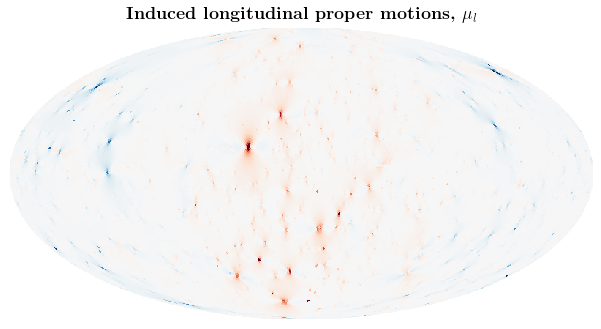

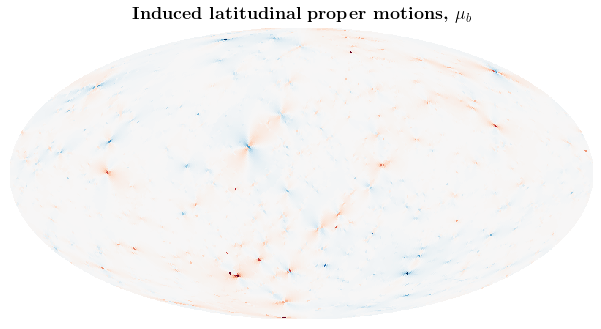

In [5]:
max_mu = 8e-4 / 0.6e-4
cmap = cmaps.RdBu_r
cmap.set_under('w')

hp.mollview(1e6 * sim.mu_qsrs[:,0] / 1e-4,max=max_mu, min=-max_mu, title=r"\bf{Induced longitudinal proper motions}, $\mu_l$", unit='$\mu$as\,yr$^{-1}$', cmap=cmap, cbar=None)
hp.mollview(1e6 * sim.mu_qsrs[:,1] / 1e-4,max=max_mu, min=-max_mu, title=r"\bf{Induced latitudinal proper motions}, $\mu_b$", unit='$\mu$as\,yr$^{-1}$', cmap=cmap, cbar=None)

In [7]:
import sys
sys.path.append("../")
from sbi.neural_nets.flow import build_maf

from sbi.neural_nets.classifier import build_mlp_mixed_classifier
from sbi import utils
import torch
import torch.nn as nn

In [8]:
from pytorch_lightning.loggers import TensorBoardLogger, MLFlowLogger
import mlflow

run_id = '1936d60ac8f945b4b6873c96a4946f32'
    
data_dir = '/scratch/sm8383/sbi-fermi/data/'
model_uri = "runs:/{}/density_estimator".format(run_id)
density_estimator = mlflow.pytorch.load_model('/Users/smsharma/PycharmProjects/sbi-astrometry/data/logs/mlruns/0/' + run_id + '/artifacts/density_estimator')

In [9]:
class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.

    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to. This means that sigma can be
            the same regardless of the scale of the vector.
    """
    def __init__(self, sigma=0.):
        super().__init__()
        self.sigma = sigma
        self.register_buffer('noise', torch.tensor(0))

    def forward(self, x):
        if self.sigma != 0.:
            sampled_noise = self.noise.expand(*x.size()).detach().float().normal_() * self.sigma
            x = x + sampled_noise
        return x 

In [11]:
mu_qsrs = 1e6 * hp.reorder(sim.mu_qsrs.T, r2n=True).T

x_test = torch.Tensor(mu_qsrs)

gn = GaussianNoise(sigma=0.0023)
x_test = gn(x_test).T

density_estimator(x_test.unsqueeze(0), torch.Tensor([150]).unsqueeze(0)).squeeze().detach().numpy()

array(-0.2384071, dtype=float32)

In [12]:

nside = 64


def make_map(map_test1, min, max, add_projscatter=False):
    dot_size=10
    rot = (120, 30,345)
    cmap = cmaps.RdBu_r
    cmap.set_under('w', alpha=1)


    # map_test1_bw = map_test1.astype(np.float)/np.max(map_test1);
    hp.visufunc.orthview(map=map_test1, half_sky=True, title='', rot=rot, cmap=cmap, cbar=False, hold=True, nest=False, min=min, max=max, notext=True);

    theta, phi = hp.pix2ang(hp.npix2nside(len(map_test1)), range(len(map_test1)), nest=True);
    if add_projscatter:
        hp.projscatter(theta, phi, c='k', s=dot_size);
    hp.graticule();
    hp.graticule(dmer=360,dpar=360,alpha=1, rot=(0,0,15), local=True);
    hp.graticule(dmer=360,dpar=360,alpha=1, rot=(0,0,195), local=True);  

In [13]:
1e6 * sim.mu_qsrs[:,0] / 1e-4

array([-0.60775904,  0.05306698, -3.4745132 , ...,  0.0614317 ,
       -0.12365487, -0.24419161])

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
  if __name__ == '__main__':
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


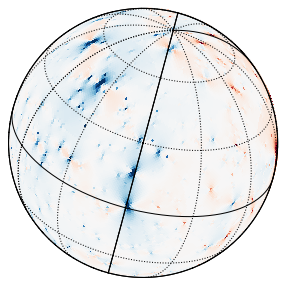

In [14]:
max_mu = 3e-4 / 0.6e-4
nside = 64

map_test1 = hp.ud_grade(1e6 * sim.mu_qsrs[:,0] / 1e-4, nside_out=nside, power=-2)
make_map(map_test1, min=-max_mu, max=max_mu)
plt.tight_layout()
plt.savefig("../paper/ml4ps/figures/input_map_1.pdf")

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
  if __name__ == '__main__':
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


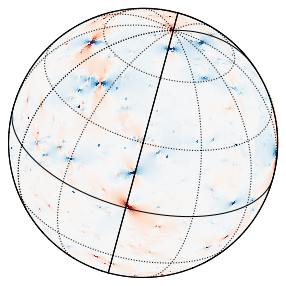

In [15]:
map_test1 = hp.ud_grade(1e6 * sim.mu_qsrs[:,1] / 1e-4, nside_out=nside, power=-1)
make_map(map_test1, min=-max_mu, max=max_mu)
plt.savefig("../paper/ml4ps/figures/input_map_2.pdf")

In [16]:
map_test1

array([-0.24358088,  0.61995942,  2.87019083, ..., -0.32519782,
       -0.35211929, -0.38030323])

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
  if __name__ == '__main__':
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.

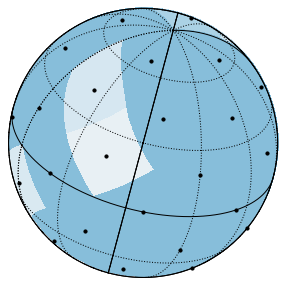

In [17]:
nside_list = [32, 16, 8, 4, 2]

for i_n, nside in enumerate(nside_list):
    for i_ch in range(3):
        map_test1 = np.load("/Users/smsharma/Desktop/x_map_{}.npy".format(i_n + 1))[0, :, i_ch]
        make_map(map_test1, add_projscatter=True if nside < 16 else False, min=-2, max=5)
        plt.savefig("../paper/ml4ps/figures/convolutional_{}_{}.pdf".format(nside, i_ch))

In [83]:
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np


    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap


Number of labels: 100


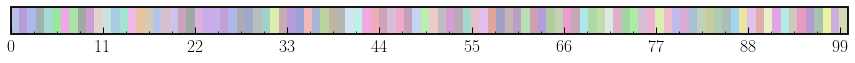

In [86]:
new_cmap = rand_cmap(100, type='soft', first_color_black=False, last_color_black=False, verbose=True)


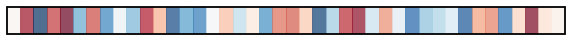

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, colorbar

vals = np.linspace(0,1, int(64 / 1.5))

np.random.shuffle(vals)

cmap = plt.cm.colors.ListedColormap(plt.cm.RdBu(vals))

fig, ax = plt.subplots(1, 1, figsize=(15 / 1.5, 0.5))

cb = colorbar.ColorbarBase(ax, cmap=cmap, spacing='proportional', ticks=None
                                   , format='%1i', orientation=u'horizontal', alpha=0.7)

plt.axis('off')
plt.savefig("../paper/ml4ps/figures/fc1.pdf")

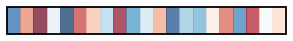

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, colorbar

vals = np.linspace(0,1,int(64 / 3))

np.random.shuffle(vals)

cmap = plt.cm.colors.ListedColormap(plt.cm.RdBu(vals))

fig, ax = plt.subplots(1, 1, figsize=(15 / 3., 0.5))

cb = colorbar.ColorbarBase(ax, cmap=cmap, spacing='proportional', ticks=None
                                   , format='%1i', orientation=u'horizontal', alpha=0.7)

plt.axis('off')
plt.savefig("../paper/ml4ps/figures/fc2.pdf")